# Risk Based Access Control : Machine Learning for Identity Threat Detection v2

In [122]:
RANDOM_STATE = 42

## Loading and renaming data

In [123]:
import pandas as pd

In [124]:
chunk_size = 1000000
chunks = []
sample_fraction_majority = 0.0001
sample_fraction_minority = 1
RANDOM_STATE = 42

for i, chunk in enumerate(pd.read_csv("data/rba-dataset.csv", chunksize=chunk_size)):
    minority_class = chunk[chunk["Is Account Takeover"] == True]
    majority_class = chunk[chunk["Is Account Takeover"] == False]

    sampled_minority = minority_class.sample(frac=sample_fraction_minority, random_state=RANDOM_STATE)
    sampled_majority = majority_class.sample(frac=sample_fraction_majority, random_state=RANDOM_STATE)

    combined_sample = pd.concat([sampled_minority, sampled_majority], axis=0)
    chunks.append(combined_sample)

    print(f"chunk {i} / 31")

data = pd.concat(chunks, axis=0)

data = data.sample(frac=1, random_state=RANDOM_STATE).reset_index(drop=True)

data.head()

chunk 0 / 31
chunk 1 / 31
chunk 2 / 31
chunk 3 / 31
chunk 4 / 31
chunk 5 / 31
chunk 6 / 31
chunk 7 / 31
chunk 8 / 31
chunk 9 / 31
chunk 10 / 31
chunk 11 / 31
chunk 12 / 31
chunk 13 / 31
chunk 14 / 31
chunk 15 / 31
chunk 16 / 31
chunk 17 / 31
chunk 18 / 31
chunk 19 / 31
chunk 20 / 31
chunk 21 / 31
chunk 22 / 31
chunk 23 / 31
chunk 24 / 31
chunk 25 / 31
chunk 26 / 31
chunk 27 / 31
chunk 28 / 31
chunk 29 / 31
chunk 30 / 31
chunk 31 / 31


,index,Login Timestamp,User ID,Round-Trip Time [ms],IP Address,Country,Region,City,ASN,User Agent String,Browser Name and Version,OS Name and Version,Device Type,Login Successful,Is Attack IP,Is Account Takeover
0,29244518,2021-02-03 02:41:58.307,8883596012754605922,NaN,170.39.78.3,US,-,-,393398,Mozilla/5.0 (iPhone; CPU iPhone OS 13_4 like ...,Chrome Mobile 81.0.4044,iOS 13.4,mobile,False,False,False
1,1105008,2020-02-18 00:56:20.230,3037641017366924328,NaN,156.52.180.228,NO,Viken,Fredrikstad,29695,Mozilla/5.0 (Linux; U; Android 2.2) Gecko/201...,Firefox 20.0.0.1618,Android 2.2,mobile,True,False,False
2,3031315,2020-03-15 16:57:13.252,2446886407948496390,NaN,139.164.229.21,NO,Viken,Drammen,29695,Mozilla/5.0 (iPhone; CPU iPhone OS 11_2_6 lik...,Chrome Mobile 81.0.4044,iOS 11.2.6,mobile,True,False,False
3,1331290,2020-02-20 19:41:10.650,9218785402660907923,NaN,45.13.240.204,NO,-,-,29695,Mozilla/5.0 (iPhone; CPU iPhone OS 9_0_2 like...,Android 2.3.6,iOS 9.0.2,tablet,True,False,False
4,27480866,2021-01-13 02:58:11.697,-4324475583306591935,NaN,10.0.52.159,DE,-,-,500254,VLC/3.0.0-git LibVLC/3.0.0-git,VLC 3.0.0-git,Other,unknown,False,True,False


### Renaming our column

In [125]:
new_names = {
    "Login Timestamp": "timestamp",
    "User ID": "id",
    "Round-Trip Time [ms]": "rtt_ms",
    "IP Address": "ip",
    "Country": "country",
    "Region": "region",
    "City": "city",
    "ASN": "asn",
    "User Agent String": "user_agent",
    "Browser Name and Version": "browser",
    "OS Name and Version": "os",
    "Device Type": "device",
    "Login Successful": "login_success",
    "Is Attack IP": "is_attack_ip",
    "Is Account Takeover": "is_account_takeover"
}

data.rename(columns=new_names, inplace=True)
data


,index,timestamp,id,rtt_ms,ip,country,region,city,asn,user_agent,browser,os,device,login_success,is_attack_ip,is_account_takeover
0,29244518,2021-02-03 02:41:58.307,8883596012754605922,NaN,170.39.78.3,US,-,-,393398,Mozilla/5.0 (iPhone; CPU iPhone OS 13_4 like ...,Chrome Mobile 81.0.4044,iOS 13.4,mobile,False,False,False
1,1105008,2020-02-18 00:56:20.230,3037641017366924328,NaN,156.52.180.228,NO,Viken,Fredrikstad,29695,Mozilla/5.0 (Linux; U; Android 2.2) Gecko/201...,Firefox 20.0.0.1618,Android 2.2,mobile,True,False,False
2,3031315,2020-03-15 16:57:13.252,2446886407948496390,NaN,139.164.229.21,NO,Viken,Drammen,29695,Mozilla/5.0 (iPhone; CPU iPhone OS 11_2_6 lik...,Chrome Mobile 81.0.4044,iOS 11.2.6,mobile,True,False,False
3,1331290,2020-02-20 19:41:10.650,9218785402660907923,NaN,45.13.240.204,NO,-,-,29695,Mozilla/5.0 (iPhone; CPU iPhone OS 9_0_2 like...,Android 2.3.6,iOS 9.0.2,tablet,True,False,False
4,27480866,2021-01-13 02:58:11.697,-4324475583306591935,NaN,10.0.52.159,DE,-,-,500254,VLC/3.0.0-git LibVLC/3.0.0-git,VLC 3.0.0-git,Other,unknown,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3263,10454433,2020-06-27 15:47:35.743,6710682370423549012,NaN,91.233.208.53,CZ,Kraj Vysocina,Bohdalec,31559,Mozilla/5.0 (iPhone; CPU iPhone OS 13_4 like ...,Chrome Mobile 81.0.4044.1925,iOS 13.4,mobile,True,False,False
3264,10526408,2020-06-28 15:20:27.822,-1136293028359551315,NaN,23.137.225.106,US,-,-,393398,Mozilla/5.0 (iPhone; CPU iPhone OS 11_2_6 lik...,Chrome Mobile 81.0.4044.1925,iOS 11.2.6,mobile,False,False,False
3265,12041296,2020-07-19 06:57:16.841,5140709821083845236,NaN,80.232.79.13,NO,Agder,Kristiansand,25400,Mozilla/5.0 (iPhone; CPU iPhone OS 13_4 like ...,Chrome Mobile 81.0.4044.1929,iOS 13.4,mobile,True,False,False
3266,8708580,2020-06-03 09:28:56.954,5069369253943453141,NaN,91.240.236.172,RO,Ilfov,Petrachioaia,62350,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_6...,Chrome 79.0.3945.192.218,Mac OS X 10.14.6,desktop,True,True,True


# Data Exploration

In [126]:
import matplotlib.pyplot as plt
%matplotlib inline

In [127]:
data.tail(10)

,index,timestamp,id,rtt_ms,ip,country,region,city,asn,user_agent,browser,os,device,login_success,is_attack_ip,is_account_takeover
3258,11649310,2020-07-13 13:26:30.160,-4324475583306591935,NaN,10.1.38.171,IN,-,-,132996,Mozilla/5.0 (iPhone; CPU iPhone OS 11_2_6 lik...,Chrome Mobile 81.0.4044.1937,iOS 11.2.6,mobile,False,False,False
3259,4687910,2020-04-07 07:51:36.529,6872246269705207364,NaN,158.248.233.59,NO,-,-,29695,Mozilla/5.0 (Linux; U; Android 13.0; i phone X...,Opera Mobile 52.1.2254,Android 13.0,mobile,False,False,False
3260,20779695,2020-11-15 07:54:24.734,-4324475583306591935,NaN,187.62.51.109,BR,Parana,Londrina,22689,Mozilla/5.0 (iPhone; CPU iPhone OS 13_4 like ...,Chrome Mobile 84.0.4147,iOS 13.4,mobile,False,False,False
3261,15696306,2020-09-08 17:23:13.988,-1429236325848882975,NaN,170.39.76.54,US,-,-,393398,Mozilla/5.0 (Linux; Android 5.5.1; CHM-U01) G...,Firefox Mobile 84.0,Android 5.5.1,mobile,True,False,False
3262,29507014,2021-02-06 09:04:30.694,-4324475583306591935,NaN,170.39.77.13,US,-,-,393398,Mozilla/5.0 (iPhone; CPU iPhone OS 11_2_6 lik...,Chrome Mobile WebView 85.0.4183,iOS 11.2.6,mobile,False,False,False
3263,10454433,2020-06-27 15:47:35.743,6710682370423549012,NaN,91.233.208.53,CZ,Kraj Vysocina,Bohdalec,31559,Mozilla/5.0 (iPhone; CPU iPhone OS 13_4 like ...,Chrome Mobile 81.0.4044.1925,iOS 13.4,mobile,True,False,False
3264,10526408,2020-06-28 15:20:27.822,-1136293028359551315,NaN,23.137.225.106,US,-,-,393398,Mozilla/5.0 (iPhone; CPU iPhone OS 11_2_6 lik...,Chrome Mobile 81.0.4044.1925,iOS 11.2.6,mobile,False,False,False
3265,12041296,2020-07-19 06:57:16.841,5140709821083845236,NaN,80.232.79.13,NO,Agder,Kristiansand,25400,Mozilla/5.0 (iPhone; CPU iPhone OS 13_4 like ...,Chrome Mobile 81.0.4044.1929,iOS 13.4,mobile,True,False,False
3266,8708580,2020-06-03 09:28:56.954,5069369253943453141,NaN,91.240.236.172,RO,Ilfov,Petrachioaia,62350,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_6...,Chrome 79.0.3945.192.218,Mac OS X 10.14.6,desktop,True,True,True
3267,30677814,2021-02-21 15:53:16.903,6154359082336158419,NaN,170.39.76.105,US,-,-,393398,Mozilla/5.0 (Linux; Android 4.1; Galaxy Nexus...,Chrome Mobile 49.0.2623,Android 4.1,mobile,True,False,False


In [128]:
data.dtypes

index                    int64
timestamp               object
id                       int64
rtt_ms                 float64
ip                      object
country                 object
region                  object
city                    object
asn                      int64
user_agent              object
browser                 object
os                      object
device                  object
login_success             bool
is_attack_ip              bool
is_account_takeover       bool
dtype: object

In [129]:
data.count()

index                  3268
timestamp              3268
id                     3268
rtt_ms                  141
ip                     3268
country                3268
region                 3261
city                   3268
asn                    3268
user_agent             3268
browser                3268
os                     3268
device                 3268
login_success          3268
is_attack_ip           3268
is_account_takeover    3268
dtype: int64

### Agent Data (OS, Device and Browser)

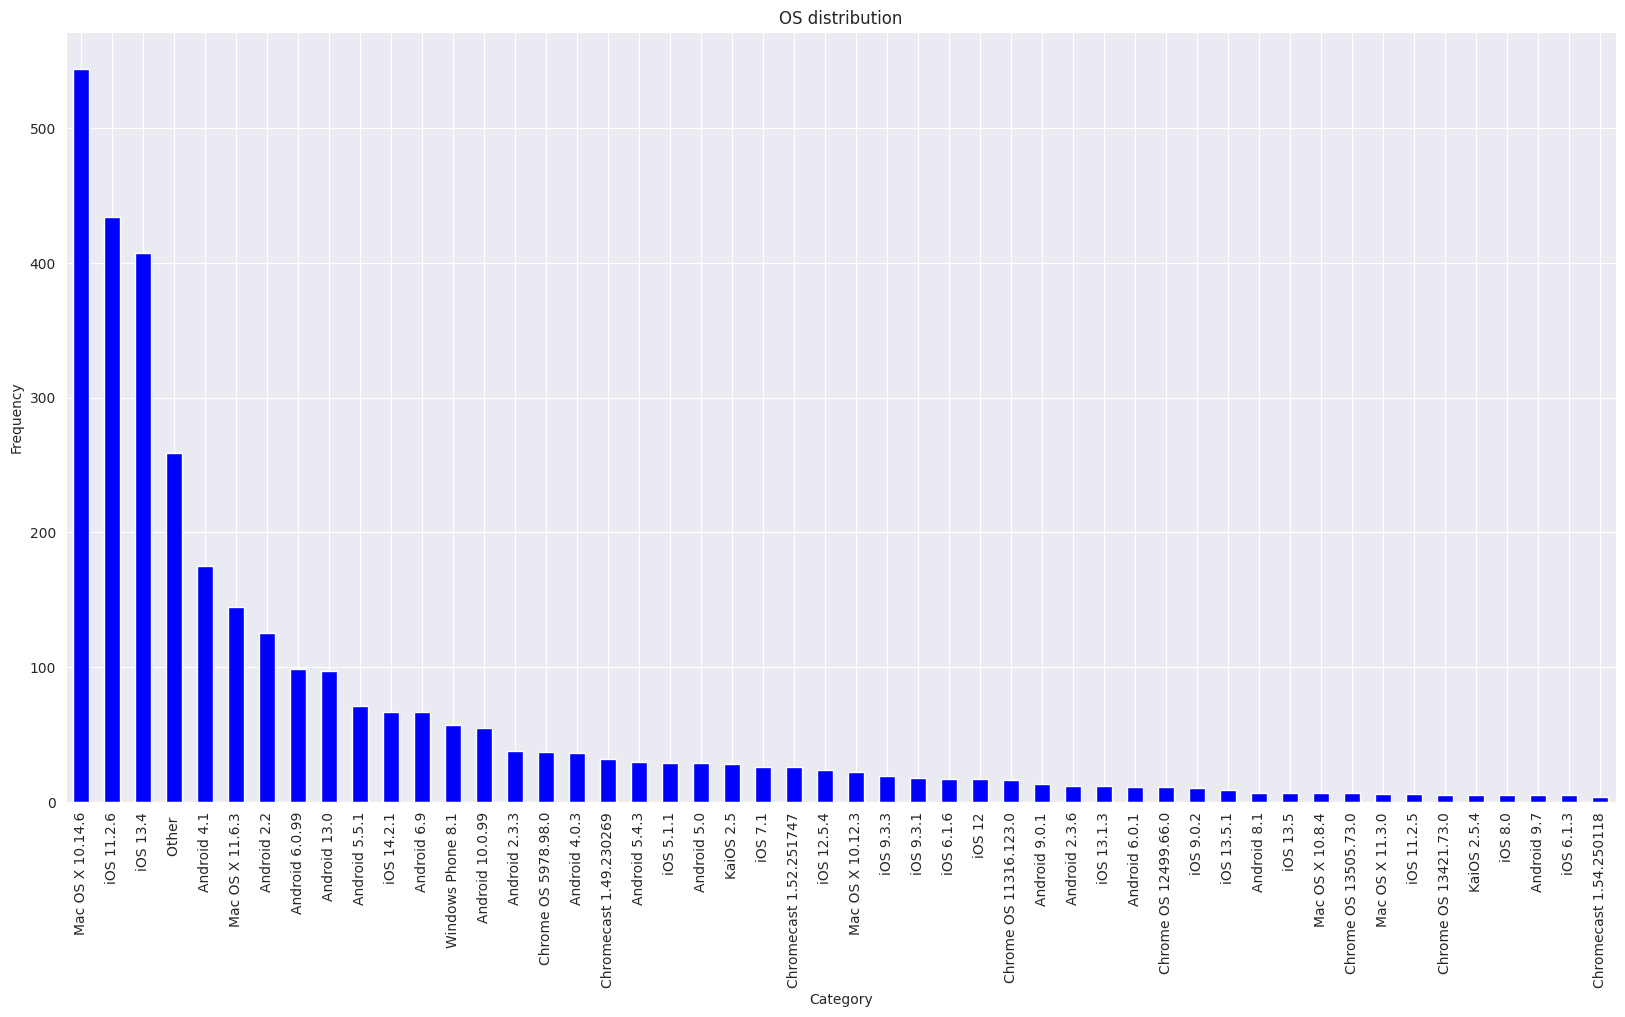

In [130]:
category_counts = data["os"].value_counts().head(50)
plt.figure(figsize=(20, 10))
category_counts.plot(kind='bar', color='blue')
plt.title('OS distribution')
plt.xlabel('Category')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.show()

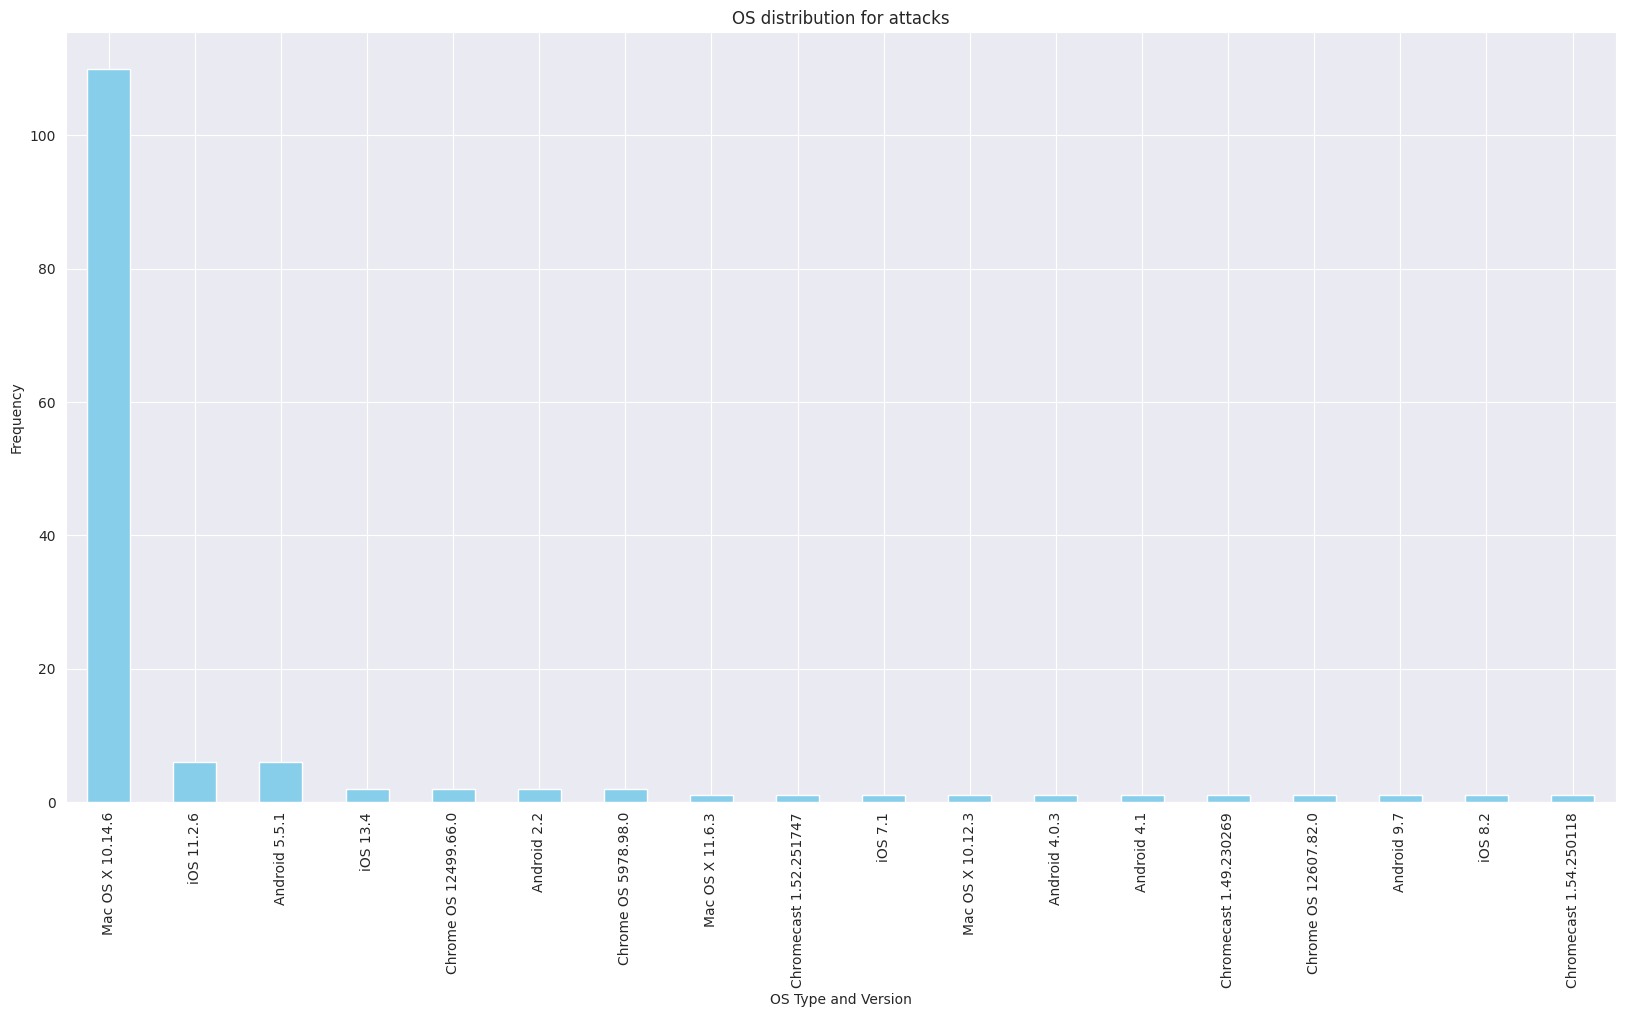

In [131]:
category_counts = data[data['is_account_takeover']==True]["os"].value_counts()
plt.figure(figsize=(20, 10))
category_counts.plot(kind='bar', color='skyblue')
plt.title('OS distribution for attacks')
plt.xlabel('OS Type and Version')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.show()

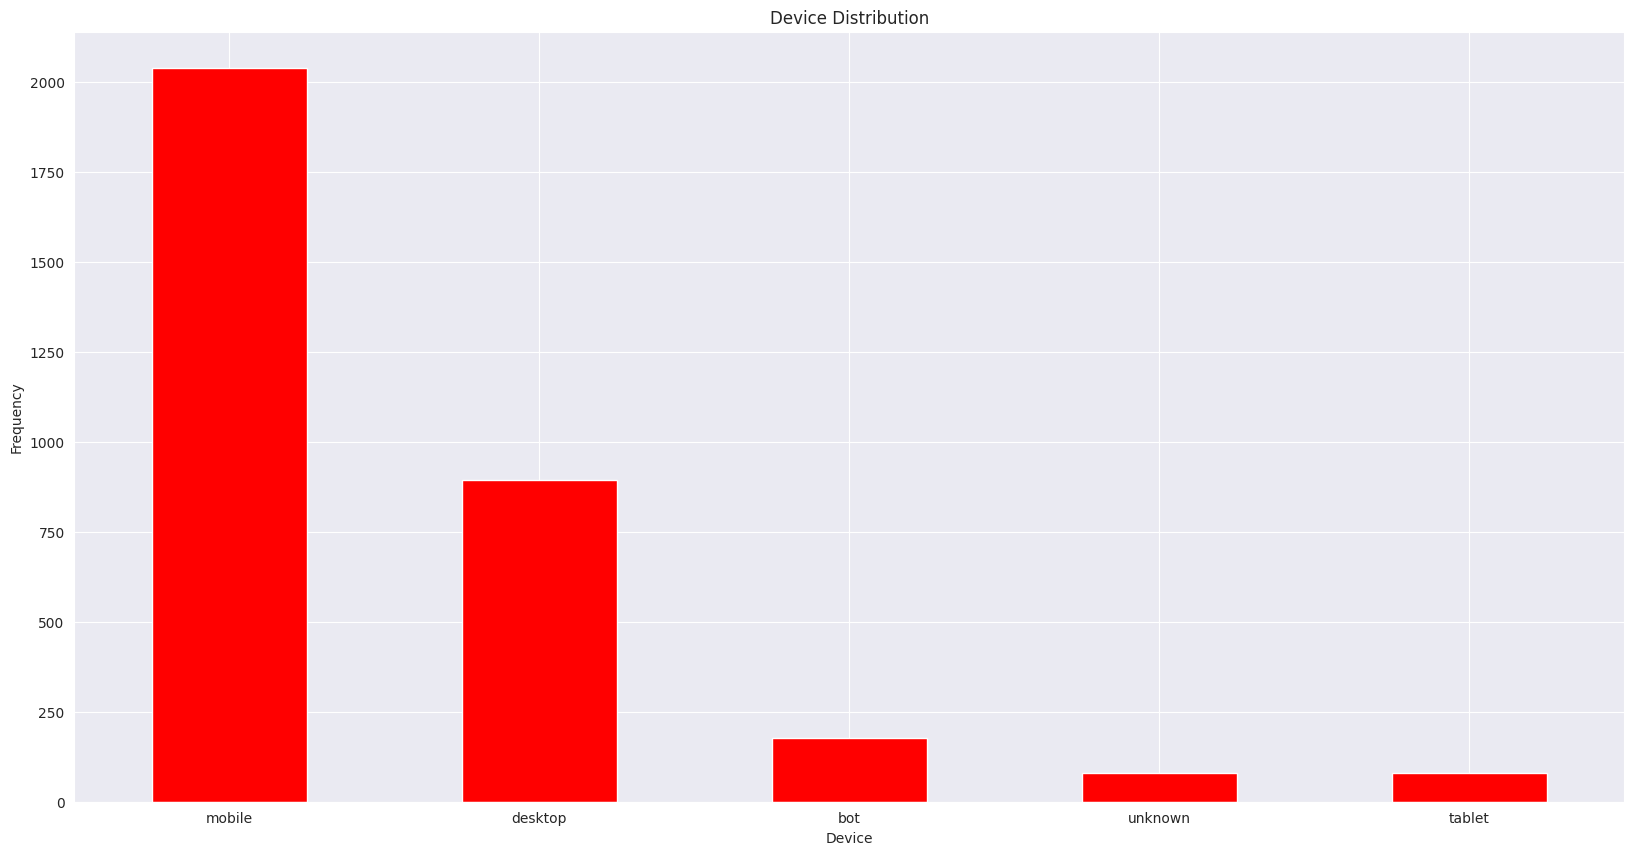

In [132]:
category_counts = data["device"].value_counts()
plt.figure(figsize=(20, 10))
category_counts.plot(kind='bar', color='red')
plt.title('Device Distribution')
plt.xlabel('Device')
plt.ylabel('Frequency')
plt.xticks(rotation=0)
plt.show()

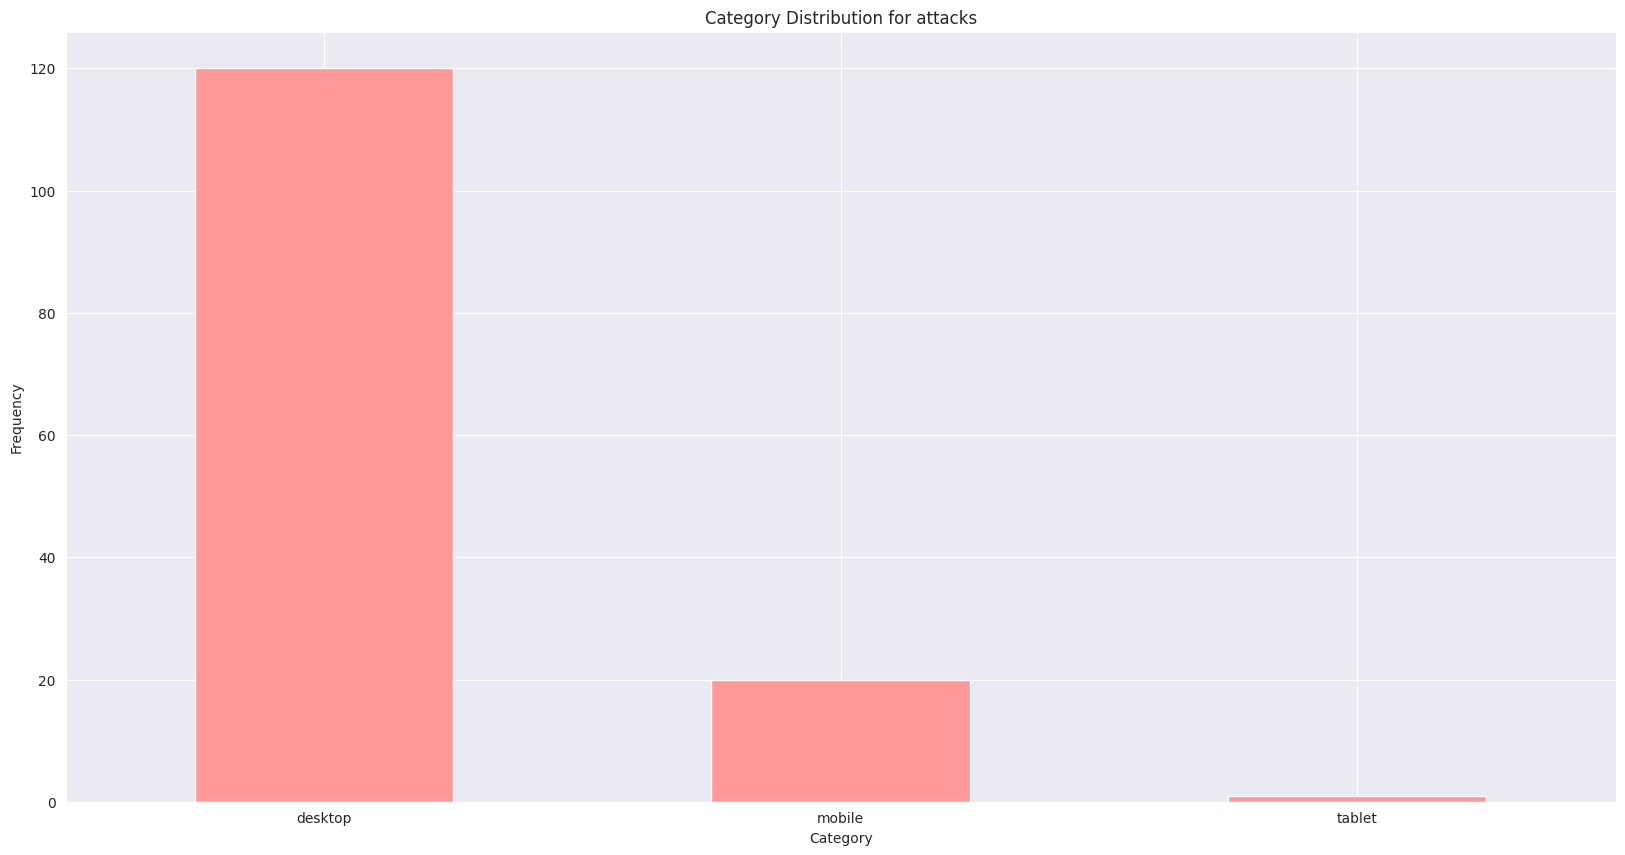

In [133]:
category_counts = data[data['is_account_takeover']==True]["device"].value_counts()
plt.figure(figsize=(20, 10))
category_counts.plot(kind='bar', color='#FF9999')
plt.title('Category Distribution for attacks')
plt.xlabel('Category')
plt.ylabel('Frequency')
plt.xticks(rotation=0)
plt.show()

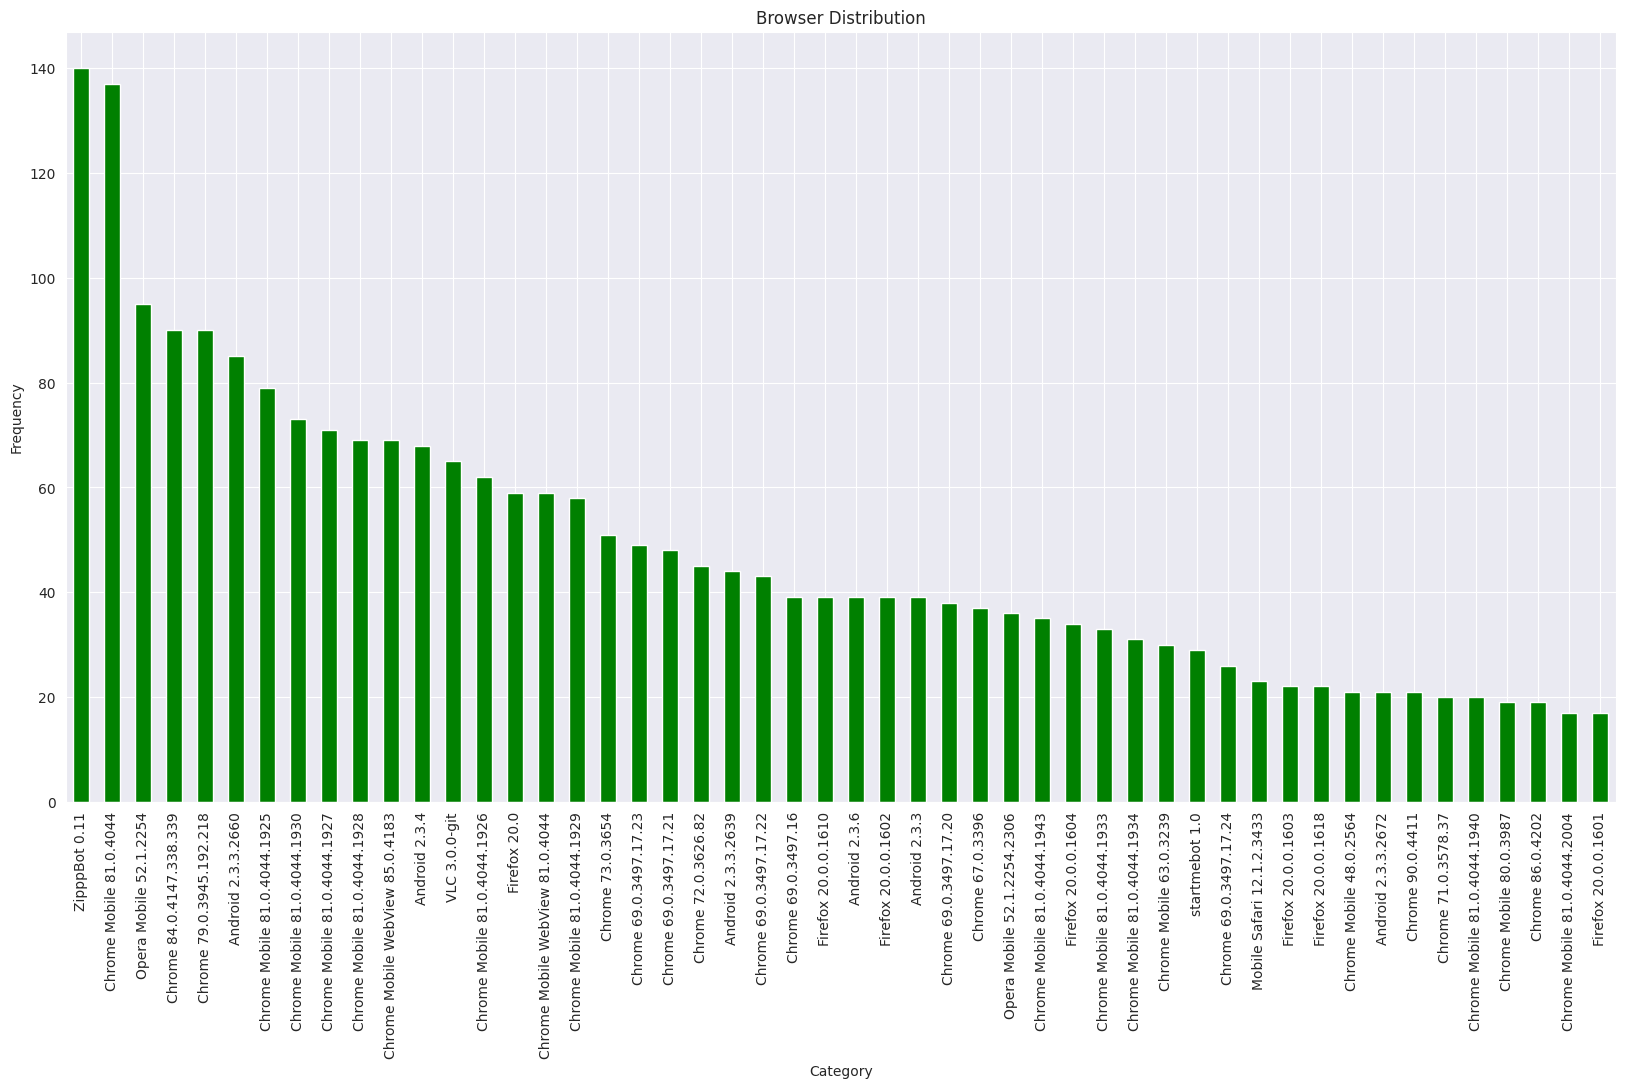

In [134]:
category_counts = data["browser"].value_counts().head(50)
plt.figure(figsize=(20, 10))
category_counts.plot(kind='bar', color='green')
plt.title('Browser Distribution')
plt.xlabel('Category')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.show()

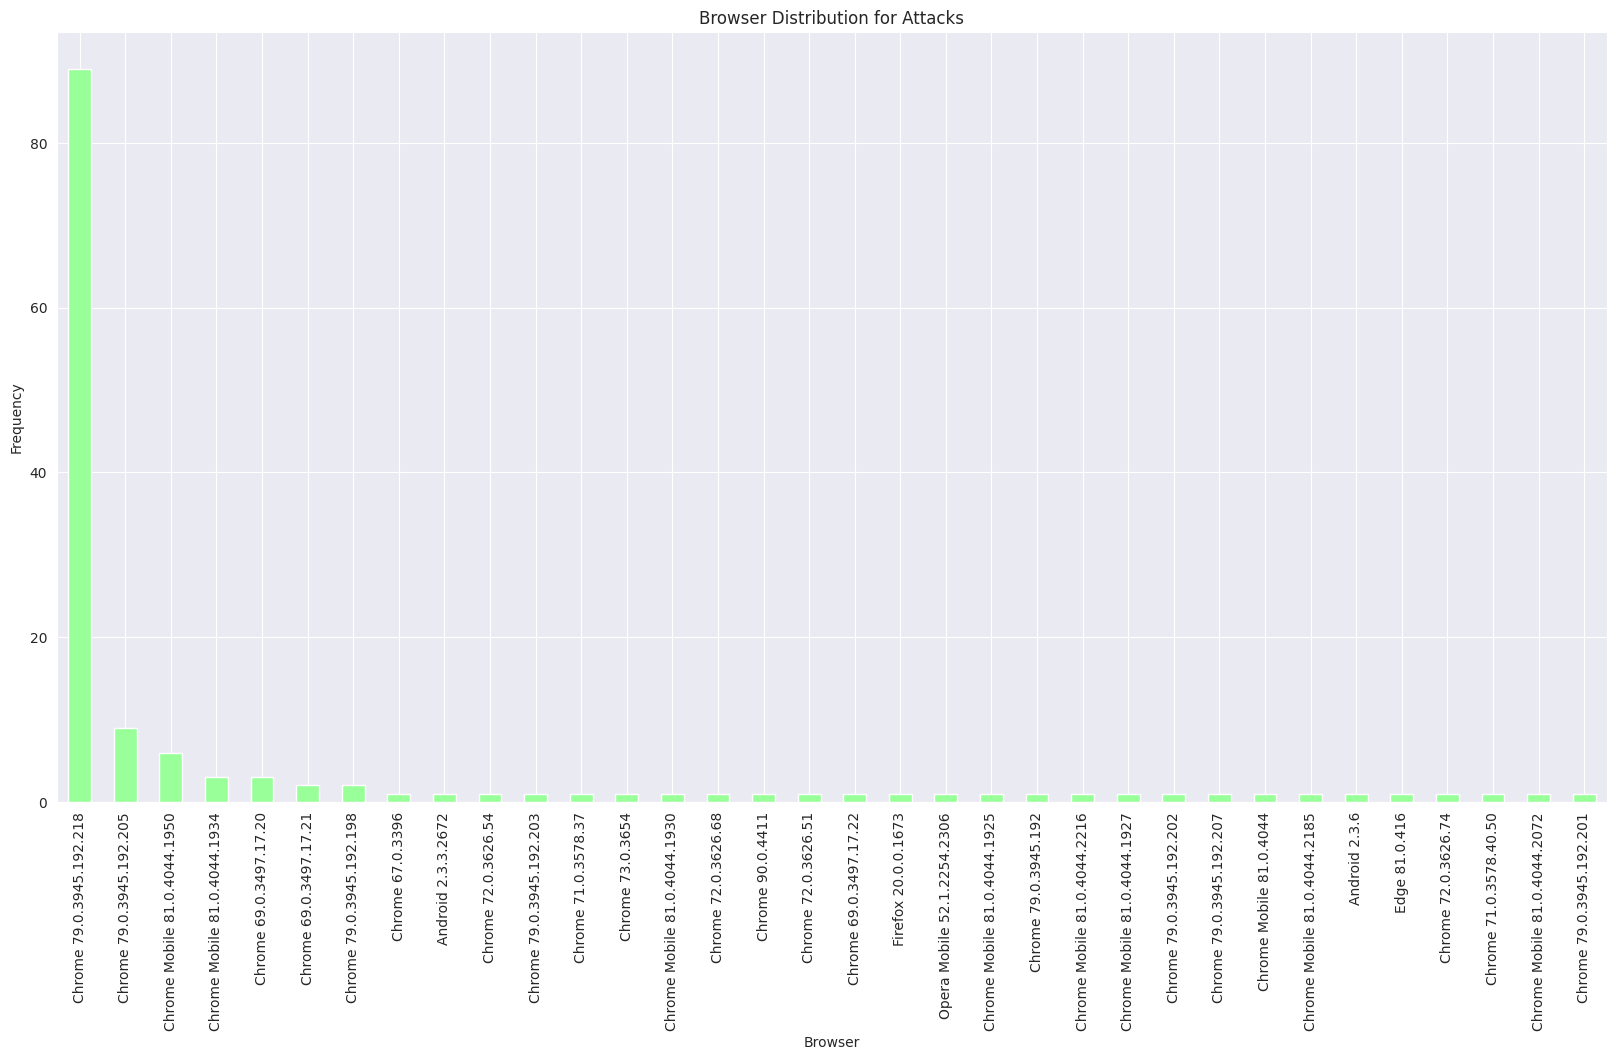

In [135]:
category_counts = data[data['is_account_takeover']==True]["browser"].value_counts().head(50)
plt.figure(figsize=(20, 10))
category_counts.plot(kind='bar', color='#99FF99')
plt.title('Browser Distribution for Attacks')
plt.xlabel('Browser')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.show()

## Geographical Data

In [136]:
import plotly.express as px

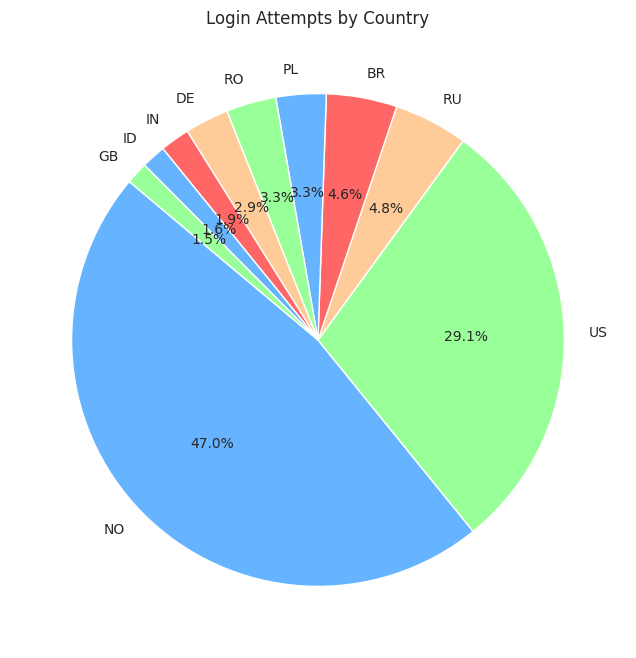

In [137]:
country_counts = data['country'].value_counts().head(10)

plt.figure(figsize=(8, 8))
plt.pie(country_counts, labels=country_counts.index, autopct='%1.1f%%', startangle=140, colors=['#66b3ff','#99ff99','#ffcc99','#ff6666'])
plt.title('Login Attempts by Country')
plt.show()

In [138]:
attack_data = data[data["is_account_takeover"] == True][['country']]
normal_connections = data[data["is_account_takeover"] != True][['country']]
normal_connections

,country
0,US
1,NO
2,NO
3,NO
4,DE
...,...
3262,US
3263,CZ
3264,US
3265,NO


In [139]:
iso2_to_iso3_map = {
    'AD': 'AND', 'AE': 'ARE', 'AF': 'AFG', 'AG': 'ATG', 'AI': 'AIA', 'AL': 'ALB',
    'AM': 'ARM', 'AO': 'AGO', 'AR': 'ARG', 'AS': 'ASM', 'AT': 'AUT', 'AU': 'AUS',
    'AW': 'ABW', 'AX': 'ALA', 'AZ': 'AZE', 'BA': 'BHS', 'BB': 'BRB', 'BD': 'BGD',
    'BE': 'BEL', 'BF': 'BFA', 'BG': 'BGR', 'BH': 'BHR', 'BI': 'BDI', 'BJ': 'BEN',
    'BL': 'BLM', 'BM': 'BMU', 'BN': 'BRN', 'BO': 'BOL', 'BQ': 'BES', 'BR': 'BRA',
    'BS': 'BHS', 'BT': 'BTN', 'BV': 'BVT', 'BW': 'BWA', 'BY': 'BLR', 'BZ': 'BLZ',
    'CA': 'CAN', 'CC': 'CCK', 'CD': 'COD', 'CF': 'CAF', 'CG': 'COG', 'CH': 'CHE',
    'CI': 'CIV', 'CK': 'COK', 'CL': 'CHL', 'CM': 'CMR', 'CN': 'CHN', 'CO': 'COL',
    'CR': 'CRI', 'CU': 'CUB', 'CV': 'CPV', 'CW': 'CUW', 'CX': 'CXR', 'CY': 'CYP',
    'CZ': 'CZE', 'DE': 'DEU', 'DJ': 'DJI', 'DK': 'DNK', 'DM': 'DMA', 'DO': 'DOM',
    'DZ': 'DZA', 'EC': 'ECU', 'EE': 'EST', 'EG': 'EGY', 'EH': 'ESH', 'ER': 'ERI',
    'ES': 'ESP', 'ET': 'ETH', 'FI': 'FIN', 'FJ': 'FJI', 'FM': 'FSM', 'FO': 'FRO',
    'FR': 'FRA', 'GA': 'GAB', 'GB': 'GBR', 'GD': 'GRD', 'GE': 'GEO', 'GF': 'GUF',
    'GG': 'GGY', 'GH': 'GHA', 'GI': 'GIB', 'GL': 'GRL', 'GM': 'GMB', 'GN': 'GIN',
    'GP': 'GLP', 'GQ': 'GNQ', 'GR': 'GRC', 'GT': 'GTM', 'GU': 'GUM', 'GW': 'GNB',
    'GY': 'GUY', 'HK': 'HKG', 'HM': 'HMD', 'HN': 'HND', 'HR': 'HRV', 'HT': 'HTI',
    'HU': 'HUN', 'ID': 'IDN', 'IE': 'IRL', 'IL': 'ISR', 'IM': 'IMN', 'IN': 'IND',
    'IO': 'IOT', 'IQ': 'IRQ', 'IR': 'IRN', 'IS': 'ISL', 'IT': 'ITA', 'JE': 'JEY',
    'JM': 'JAM', 'JO': 'JOR', 'JP': 'JPN', 'KE': 'KEN', 'KG': 'KGZ', 'KH': 'KHM',
    'KI': 'KIR', 'KM': 'COM', 'KN': 'KNA', 'KP': 'PRK', 'KR': 'KOR', 'KW': 'KWT',
    'KY': 'CYM', 'KZ': 'KAZ', 'LA': 'LAO', 'LB': 'LBN', 'LC': 'LCA', 'LI': 'LIE',
    'LK': 'LKA', 'LR': 'LBR', 'LS': 'LSO', 'LT': 'LTU', 'LU': 'LUX', 'LV': 'LVA',
    'LY': 'LBY', 'MA': 'MAR', 'MC': 'MCO', 'MD': 'MDA', 'ME': 'MNE', 'MF': 'MAF',
    'MG': 'MDG', 'MH': 'MHL', 'MK': 'MKD', 'ML': 'MLI', 'MM': 'MMR', 'MN': 'MNG',
    'MO': 'MAC', 'MP': 'MNP', 'MQ': 'MTQ', 'MR': 'MRT', 'MS': 'MSR', 'MT': 'MLT',
    'MU': 'MUS', 'MV': 'MDV', 'MW': 'MWI', 'MX': 'MEX', 'MY': 'MYS', 'MZ': 'MOZ',
    'NA': 'NAM', 'NC': 'NCL', 'NE': 'NER', 'NF': 'NFK', 'NG': 'NGA', 'NI': 'NIC',
    'NL': 'NLD', 'NO': 'NOR', 'NP': 'NPL', 'NR': 'NRU', 'NU': 'NIU', 'NZ': 'NZL',
    'OM': 'OMN', 'PA': 'PAN', 'PE': 'PER', 'PF': 'PYF', 'PG': 'PNG', 'PH': 'PHL',
    'PK': 'PAK', 'PL': 'POL', 'PM': 'SPM', 'PN': 'PCN', 'PR': 'PRI', 'PT': 'PRT',
    'PW': 'PLW', 'PY': 'PRY', 'QA': 'QAT', 'RE': 'REU', 'RO': 'ROU', 'RS': 'SRB',
    'RU': 'RUS', 'RW': 'RWA', 'SA': 'SAU', 'SB': 'SLB', 'SC': 'SYC', 'SD': 'SDN',
    'SE': 'SWE', 'SG': 'SGP', 'SH': 'SHN', 'SI': 'SVN', 'SJ': 'SJM', 'SK': 'SVK',
    'SL': 'SLE', 'SM': 'SMR', 'SN': 'SEN', 'SO': 'SOM', 'SR': 'SUR', 'SS': 'SSD',
    'ST': 'STP', 'SV': 'SLV', 'SX': 'SXM', 'SY': 'SYR', 'SZ': 'SWZ', 'TC': 'TCA',
    'TD': 'TCD', 'TF': 'ATF', 'TG': 'TGO', 'TH': 'THA', 'TJ': 'TJK', 'TK': 'TKL',
    'TL': 'TLS', 'TM': 'TKM', 'TN': 'TUN', 'TO': 'TON', 'TR': 'TUR', 'TT': 'TTO',
    'TV': 'TUV', 'TZ': 'TZA', 'UA': 'UKR', 'UG': 'UGA', 'UM': 'UMI', 'US': 'USA',
    'UY': 'URY', 'UZ': 'UZB', 'VA': 'VAT', 'VC': 'VCT', 'VE': 'VEN', 'VG': 'VGB',
    'VI': 'VIR', 'VN': 'VNM', 'VU': 'VUT', 'WF': 'WLF', 'WS': 'WSM', 'YE': 'YEM',
    'YT': 'MYT', 'ZA': 'ZAF', 'ZM': 'ZMB', 'ZW': 'ZWE'
}

def iso2_to_iso3(iso2):
    return iso2_to_iso3_map.get(iso2.upper(), iso2)


attack_data['country'] = data['country'].apply(iso2_to_iso3)
normal_connections['country'] = data['country'].apply(iso2_to_iso3)

In [140]:
attack_counts = attack_data.groupby("country").size().reset_index(name="Attack Count")
normal_connections = normal_connections.groupby("country").size().reset_index(name="Connections Count")

In [141]:
attack_counts.sort_values(by='Attack Count' , ascending=False)

,country,Attack Count
13,ROU,79
11,NOR,10
1,BRA,9
2,CAN,9
6,IDN,9
7,ITA,7
5,DNK,5
3,CHL,3
8,LVA,3
4,CZE,2


In [142]:
fig = px.choropleth(
    attack_counts,
    locations="country",
    locationmode="ISO-3",
    color="Attack Count",
    title="Number of Attacks by Country",
    color_continuous_scale="Reds"
)
fig.update_layout(
    width=1200,
    height=600
)
fig.show()

In [143]:
normal_connections.sort_values(by='Connections Count' , ascending=False)

,country,Connections Count
51,NOR,1347
69,USA,842
58,RUS,140
10,BRA,125
55,POL,95
...,...,...
59,SAU,1
63,SVN,1
66,TW,1
70,VGB,1


In [144]:
fig = px.choropleth(
    normal_connections,
    locations="country",
    locationmode="ISO-3",
    color="Connections Count",
    title="Map of Normal Connections by Country",
    color_continuous_scale="Blues"
)
fig.update_layout(
    width=1200,
    height=600
)
fig.show()

## Missing Data

In [145]:
data.isnull().sum()

index                     0
timestamp                 0
id                        0
rtt_ms                 3127
ip                        0
country                   0
region                    7
city                      0
asn                       0
user_agent                0
browser                   0
os                        0
device                    0
login_success             0
is_attack_ip              0
is_account_takeover       0
dtype: int64

In [146]:
missing_rtt = data['rtt_ms'].isnull().sum() / len(data) * 100
missing_rtt

np.float64(95.68543451652387)

In [147]:
data = data.drop(columns=['rtt_ms', 'region', 'city'])

In [148]:
data['device'].fillna(data['device'].mode()[0])

0        mobile
1        mobile
2        mobile
3        tablet
4       unknown
         ...   
3263     mobile
3264     mobile
3265     mobile
3266    desktop
3267     mobile
Name: device, Length: 3268, dtype: object

## Time Data

In [149]:
data['timestamp'] = pd.to_datetime(data['timestamp'], errors='coerce')

In [150]:
data['hour'] = data['timestamp'].dt.hour
data['day'] = data['timestamp'].dt.day_name()
data

,index,timestamp,id,ip,country,asn,user_agent,browser,os,device,login_success,is_attack_ip,is_account_takeover,hour,day
0,29244518,2021-02-03 02:41:58.307,8883596012754605922,170.39.78.3,US,393398,Mozilla/5.0 (iPhone; CPU iPhone OS 13_4 like ...,Chrome Mobile 81.0.4044,iOS 13.4,mobile,False,False,False,2,Wednesday
1,1105008,2020-02-18 00:56:20.230,3037641017366924328,156.52.180.228,NO,29695,Mozilla/5.0 (Linux; U; Android 2.2) Gecko/201...,Firefox 20.0.0.1618,Android 2.2,mobile,True,False,False,0,Tuesday
2,3031315,2020-03-15 16:57:13.252,2446886407948496390,139.164.229.21,NO,29695,Mozilla/5.0 (iPhone; CPU iPhone OS 11_2_6 lik...,Chrome Mobile 81.0.4044,iOS 11.2.6,mobile,True,False,False,16,Sunday
3,1331290,2020-02-20 19:41:10.650,9218785402660907923,45.13.240.204,NO,29695,Mozilla/5.0 (iPhone; CPU iPhone OS 9_0_2 like...,Android 2.3.6,iOS 9.0.2,tablet,True,False,False,19,Thursday
4,27480866,2021-01-13 02:58:11.697,-4324475583306591935,10.0.52.159,DE,500254,VLC/3.0.0-git LibVLC/3.0.0-git,VLC 3.0.0-git,Other,unknown,False,True,False,2,Wednesday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3263,10454433,2020-06-27 15:47:35.743,6710682370423549012,91.233.208.53,CZ,31559,Mozilla/5.0 (iPhone; CPU iPhone OS 13_4 like ...,Chrome Mobile 81.0.4044.1925,iOS 13.4,mobile,True,False,False,15,Saturday
3264,10526408,2020-06-28 15:20:27.822,-1136293028359551315,23.137.225.106,US,393398,Mozilla/5.0 (iPhone; CPU iPhone OS 11_2_6 lik...,Chrome Mobile 81.0.4044.1925,iOS 11.2.6,mobile,False,False,False,15,Sunday
3265,12041296,2020-07-19 06:57:16.841,5140709821083845236,80.232.79.13,NO,25400,Mozilla/5.0 (iPhone; CPU iPhone OS 13_4 like ...,Chrome Mobile 81.0.4044.1929,iOS 13.4,mobile,True,False,False,6,Sunday
3266,8708580,2020-06-03 09:28:56.954,5069369253943453141,91.240.236.172,RO,62350,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_6...,Chrome 79.0.3945.192.218,Mac OS X 10.14.6,desktop,True,True,True,9,Wednesday


In [151]:
def categorize_time_of_day(hour):
    if 5 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 17:
        return 'Afternoon'
    elif 17 <= hour < 21:
        return 'Evening'
    else:
        return 'Night'

data['time'] = data['hour'].apply(categorize_time_of_day)
data


,index,timestamp,id,ip,country,asn,user_agent,browser,os,device,login_success,is_attack_ip,is_account_takeover,hour,day,time
0,29244518,2021-02-03 02:41:58.307,8883596012754605922,170.39.78.3,US,393398,Mozilla/5.0 (iPhone; CPU iPhone OS 13_4 like ...,Chrome Mobile 81.0.4044,iOS 13.4,mobile,False,False,False,2,Wednesday,Night
1,1105008,2020-02-18 00:56:20.230,3037641017366924328,156.52.180.228,NO,29695,Mozilla/5.0 (Linux; U; Android 2.2) Gecko/201...,Firefox 20.0.0.1618,Android 2.2,mobile,True,False,False,0,Tuesday,Night
2,3031315,2020-03-15 16:57:13.252,2446886407948496390,139.164.229.21,NO,29695,Mozilla/5.0 (iPhone; CPU iPhone OS 11_2_6 lik...,Chrome Mobile 81.0.4044,iOS 11.2.6,mobile,True,False,False,16,Sunday,Afternoon
3,1331290,2020-02-20 19:41:10.650,9218785402660907923,45.13.240.204,NO,29695,Mozilla/5.0 (iPhone; CPU iPhone OS 9_0_2 like...,Android 2.3.6,iOS 9.0.2,tablet,True,False,False,19,Thursday,Evening
4,27480866,2021-01-13 02:58:11.697,-4324475583306591935,10.0.52.159,DE,500254,VLC/3.0.0-git LibVLC/3.0.0-git,VLC 3.0.0-git,Other,unknown,False,True,False,2,Wednesday,Night
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3263,10454433,2020-06-27 15:47:35.743,6710682370423549012,91.233.208.53,CZ,31559,Mozilla/5.0 (iPhone; CPU iPhone OS 13_4 like ...,Chrome Mobile 81.0.4044.1925,iOS 13.4,mobile,True,False,False,15,Saturday,Afternoon
3264,10526408,2020-06-28 15:20:27.822,-1136293028359551315,23.137.225.106,US,393398,Mozilla/5.0 (iPhone; CPU iPhone OS 11_2_6 lik...,Chrome Mobile 81.0.4044.1925,iOS 11.2.6,mobile,False,False,False,15,Sunday,Afternoon
3265,12041296,2020-07-19 06:57:16.841,5140709821083845236,80.232.79.13,NO,25400,Mozilla/5.0 (iPhone; CPU iPhone OS 13_4 like ...,Chrome Mobile 81.0.4044.1929,iOS 13.4,mobile,True,False,False,6,Sunday,Morning
3266,8708580,2020-06-03 09:28:56.954,5069369253943453141,91.240.236.172,RO,62350,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_6...,Chrome 79.0.3945.192.218,Mac OS X 10.14.6,desktop,True,True,True,9,Wednesday,Morning


In [152]:
data['is_account_takeover'] = data['is_account_takeover'].astype(int)
data['is_attack_ip'] = data['is_attack_ip'].astype(int) #!!!!!!!!!!!!! inspect this one later
data['login_success'] = data['login_success'].astype(int)

In [153]:
data

,index,timestamp,id,ip,country,asn,user_agent,browser,os,device,login_success,is_attack_ip,is_account_takeover,hour,day,time
0,29244518,2021-02-03 02:41:58.307,8883596012754605922,170.39.78.3,US,393398,Mozilla/5.0 (iPhone; CPU iPhone OS 13_4 like ...,Chrome Mobile 81.0.4044,iOS 13.4,mobile,0,0,0,2,Wednesday,Night
1,1105008,2020-02-18 00:56:20.230,3037641017366924328,156.52.180.228,NO,29695,Mozilla/5.0 (Linux; U; Android 2.2) Gecko/201...,Firefox 20.0.0.1618,Android 2.2,mobile,1,0,0,0,Tuesday,Night
2,3031315,2020-03-15 16:57:13.252,2446886407948496390,139.164.229.21,NO,29695,Mozilla/5.0 (iPhone; CPU iPhone OS 11_2_6 lik...,Chrome Mobile 81.0.4044,iOS 11.2.6,mobile,1,0,0,16,Sunday,Afternoon
3,1331290,2020-02-20 19:41:10.650,9218785402660907923,45.13.240.204,NO,29695,Mozilla/5.0 (iPhone; CPU iPhone OS 9_0_2 like...,Android 2.3.6,iOS 9.0.2,tablet,1,0,0,19,Thursday,Evening
4,27480866,2021-01-13 02:58:11.697,-4324475583306591935,10.0.52.159,DE,500254,VLC/3.0.0-git LibVLC/3.0.0-git,VLC 3.0.0-git,Other,unknown,0,1,0,2,Wednesday,Night
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3263,10454433,2020-06-27 15:47:35.743,6710682370423549012,91.233.208.53,CZ,31559,Mozilla/5.0 (iPhone; CPU iPhone OS 13_4 like ...,Chrome Mobile 81.0.4044.1925,iOS 13.4,mobile,1,0,0,15,Saturday,Afternoon
3264,10526408,2020-06-28 15:20:27.822,-1136293028359551315,23.137.225.106,US,393398,Mozilla/5.0 (iPhone; CPU iPhone OS 11_2_6 lik...,Chrome Mobile 81.0.4044.1925,iOS 11.2.6,mobile,0,0,0,15,Sunday,Afternoon
3265,12041296,2020-07-19 06:57:16.841,5140709821083845236,80.232.79.13,NO,25400,Mozilla/5.0 (iPhone; CPU iPhone OS 13_4 like ...,Chrome Mobile 81.0.4044.1929,iOS 13.4,mobile,1,0,0,6,Sunday,Morning
3266,8708580,2020-06-03 09:28:56.954,5069369253943453141,91.240.236.172,RO,62350,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_6...,Chrome 79.0.3945.192.218,Mac OS X 10.14.6,desktop,1,1,1,9,Wednesday,Morning


## Categorical Data

In [154]:
categorical_columns = data.select_dtypes(include=['object'])
categorical_columns.columns

Index(['ip', 'country', 'user_agent', 'browser', 'os', 'device', 'day',
       'time'],
      dtype='object')

### IP Address and ASN

In [155]:
data['ip'].value_counts().sort_values(ascending=False)

ip
10.3.205.197     40
23.137.225.33    29
10.3.205.195     26
10.3.205.194     20
10.3.205.196     13
                 ..
5.180.170.198     1
187.73.165.36     1
10.4.120.159      1
110.93.26.56      1
170.39.79.104     1
Name: count, Length: 2845, dtype: int64

In [156]:
ip_counts = data['ip'].value_counts()
data['ip_connection_count'] = data['ip'].map(ip_counts)

In [157]:
data['asn'].value_counts().sort_values(ascending=False)

asn
29695     835
393398    703
41164     152
15599     140
262582    138
         ... 
500004      1
34971       1
505051      1
28654       1
31559       1
Name: count, Length: 356, dtype: int64

In [158]:
asn_counts = data['asn'].value_counts()
data['asn_count'] = data['asn'].map(asn_counts)
data

,index,timestamp,id,ip,country,asn,user_agent,browser,os,device,login_success,is_attack_ip,is_account_takeover,hour,day,time,ip_connection_count,asn_count
0,29244518,2021-02-03 02:41:58.307,8883596012754605922,170.39.78.3,US,393398,Mozilla/5.0 (iPhone; CPU iPhone OS 13_4 like ...,Chrome Mobile 81.0.4044,iOS 13.4,mobile,0,0,0,2,Wednesday,Night,1,703
1,1105008,2020-02-18 00:56:20.230,3037641017366924328,156.52.180.228,NO,29695,Mozilla/5.0 (Linux; U; Android 2.2) Gecko/201...,Firefox 20.0.0.1618,Android 2.2,mobile,1,0,0,0,Tuesday,Night,1,835
2,3031315,2020-03-15 16:57:13.252,2446886407948496390,139.164.229.21,NO,29695,Mozilla/5.0 (iPhone; CPU iPhone OS 11_2_6 lik...,Chrome Mobile 81.0.4044,iOS 11.2.6,mobile,1,0,0,16,Sunday,Afternoon,1,835
3,1331290,2020-02-20 19:41:10.650,9218785402660907923,45.13.240.204,NO,29695,Mozilla/5.0 (iPhone; CPU iPhone OS 9_0_2 like...,Android 2.3.6,iOS 9.0.2,tablet,1,0,0,19,Thursday,Evening,1,835
4,27480866,2021-01-13 02:58:11.697,-4324475583306591935,10.0.52.159,DE,500254,VLC/3.0.0-git LibVLC/3.0.0-git,VLC 3.0.0-git,Other,unknown,0,1,0,2,Wednesday,Night,6,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3263,10454433,2020-06-27 15:47:35.743,6710682370423549012,91.233.208.53,CZ,31559,Mozilla/5.0 (iPhone; CPU iPhone OS 13_4 like ...,Chrome Mobile 81.0.4044.1925,iOS 13.4,mobile,1,0,0,15,Saturday,Afternoon,1,1
3264,10526408,2020-06-28 15:20:27.822,-1136293028359551315,23.137.225.106,US,393398,Mozilla/5.0 (iPhone; CPU iPhone OS 11_2_6 lik...,Chrome Mobile 81.0.4044.1925,iOS 11.2.6,mobile,0,0,0,15,Sunday,Afternoon,1,703
3265,12041296,2020-07-19 06:57:16.841,5140709821083845236,80.232.79.13,NO,25400,Mozilla/5.0 (iPhone; CPU iPhone OS 13_4 like ...,Chrome Mobile 81.0.4044.1929,iOS 13.4,mobile,1,0,0,6,Sunday,Morning,1,33
3266,8708580,2020-06-03 09:28:56.954,5069369253943453141,91.240.236.172,RO,62350,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_6...,Chrome 79.0.3945.192.218,Mac OS X 10.14.6,desktop,1,1,1,9,Wednesday,Morning,5,15


### Country

In [159]:
data['country'].value_counts().sort_values(ascending=False)

country
NO    1357
US     842
RU     140
BR     134
PL      95
      ... 
LB       1
GR       1
BY       1
PH       1
MZ       1
Name: count, Length: 75, dtype: int64

In [160]:
k = 6
kp = 2
top_k_countries_normal = data["country"].value_counts().nlargest(k).index
top_kp_countries_attacks = data[data['is_account_takeover']==True]["country"].value_counts().nlargest(kp).index
top_countries = top_k_countries_normal.union(top_kp_countries_attacks)

data["country"] = data["country"].apply(lambda x: x if x in top_countries else "other")

In [161]:
data['country'].value_counts().sort_values(ascending=False)

country
NO       1357
US        842
other     605
RU        140
BR        134
RO         95
PL         95
Name: count, dtype: int64

### Browser

In [162]:
data['browser'].value_counts().sort_values(ascending=False)

browser
ZipppBot 0.11                      140
Chrome Mobile 81.0.4044            137
Opera Mobile 52.1.2254              95
Chrome 79.0.3945.192.218            90
Chrome 84.0.4147.338.339            90
                                  ... 
Chrome Mobile 81.0.4044.2002         1
Firefox Mobile 48.0.0.3128.3143      1
Firefox 20.0.0.1606                  1
Chrome 86.0.4240.378                 1
Firefox 20.0.0.1608                  1
Name: count, Length: 312, dtype: int64

In [163]:
most_attacks_browser = data[data['is_account_takeover']==True]['browser'].value_counts().nlargest(1).index

get_browser_name = lambda x: x if x in most_attacks_browser else x.split()[0]
data['browser'] = data['browser'].apply(get_browser_name)

In [164]:
k = 8
top_k_browsers = data["browser"].value_counts().nlargest(k).index
data["browser"] = data["browser"].apply(lambda x:
                                        x if x in top_k_browsers or x in most_attacks_browser
                                        else "other")

In [165]:
data['browser'].value_counts().sort_values(ascending=False)

browser
Chrome                      1999
Android                      339
Firefox                      303
Opera                        151
ZipppBot                     140
other                        140
Chrome 79.0.3945.192.218      90
VLC                           65
Mobile                        41
Name: count, dtype: int64

## OS

In [166]:
data['os'] = data['os'].apply(lambda x : x.split()[0])

In [167]:
data['os'].value_counts().sort_values(ascending=False)

os
iOS           1145
Android        878
Mac            739
Other          259
Chrome          91
Chromecast      64
Windows         58
KaiOS           33
BlackBerry       1
Name: count, dtype: int64

In [168]:
k = 8
top_k_os = data["os"].value_counts().nlargest(k).index
most_attacks_os = data[data['is_account_takeover']==True]['os'].value_counts().nlargest(1).index

data["os"] = data["os"].apply(lambda x: x if x in top_k_os or x in most_attacks_os else "other")

In [169]:
data['os'].value_counts().sort_values(ascending=False)

os
iOS           1145
Android        878
Mac            739
Other          259
Chrome          91
Chromecast      64
Windows         58
KaiOS           33
other            1
Name: count, dtype: int64

## Device

In [170]:
data['device'].value_counts().sort_values(ascending=False)

device
mobile     2038
desktop     894
bot         176
unknown      80
tablet       80
Name: count, dtype: int64

In [171]:
data

,index,timestamp,id,ip,country,asn,user_agent,browser,os,device,login_success,is_attack_ip,is_account_takeover,hour,day,time,ip_connection_count,asn_count
0,29244518,2021-02-03 02:41:58.307,8883596012754605922,170.39.78.3,US,393398,Mozilla/5.0 (iPhone; CPU iPhone OS 13_4 like ...,Chrome,iOS,mobile,0,0,0,2,Wednesday,Night,1,703
1,1105008,2020-02-18 00:56:20.230,3037641017366924328,156.52.180.228,NO,29695,Mozilla/5.0 (Linux; U; Android 2.2) Gecko/201...,Firefox,Android,mobile,1,0,0,0,Tuesday,Night,1,835
2,3031315,2020-03-15 16:57:13.252,2446886407948496390,139.164.229.21,NO,29695,Mozilla/5.0 (iPhone; CPU iPhone OS 11_2_6 lik...,Chrome,iOS,mobile,1,0,0,16,Sunday,Afternoon,1,835
3,1331290,2020-02-20 19:41:10.650,9218785402660907923,45.13.240.204,NO,29695,Mozilla/5.0 (iPhone; CPU iPhone OS 9_0_2 like...,Android,iOS,tablet,1,0,0,19,Thursday,Evening,1,835
4,27480866,2021-01-13 02:58:11.697,-4324475583306591935,10.0.52.159,other,500254,VLC/3.0.0-git LibVLC/3.0.0-git,VLC,Other,unknown,0,1,0,2,Wednesday,Night,6,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3263,10454433,2020-06-27 15:47:35.743,6710682370423549012,91.233.208.53,other,31559,Mozilla/5.0 (iPhone; CPU iPhone OS 13_4 like ...,Chrome,iOS,mobile,1,0,0,15,Saturday,Afternoon,1,1
3264,10526408,2020-06-28 15:20:27.822,-1136293028359551315,23.137.225.106,US,393398,Mozilla/5.0 (iPhone; CPU iPhone OS 11_2_6 lik...,Chrome,iOS,mobile,0,0,0,15,Sunday,Afternoon,1,703
3265,12041296,2020-07-19 06:57:16.841,5140709821083845236,80.232.79.13,NO,25400,Mozilla/5.0 (iPhone; CPU iPhone OS 13_4 like ...,Chrome,iOS,mobile,1,0,0,6,Sunday,Morning,1,33
3266,8708580,2020-06-03 09:28:56.954,5069369253943453141,91.240.236.172,RO,62350,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_6...,Chrome 79.0.3945.192.218,Mac,desktop,1,1,1,9,Wednesday,Morning,5,15


In [172]:
filtered_columns = ['day',
                    'time',
                    'ip_connection_count',
                    'asn_count',
                    'country',
                    'os',
                    'browser',
                    'device',
                    'login_success',
                   # 'is_attack_ip',
                    'is_account_takeover'
                    ]
data_filtered = data[filtered_columns]
data_filtered

,day,time,ip_connection_count,asn_count,country,os,browser,device,login_success,is_account_takeover
0,Wednesday,Night,1,703,US,iOS,Chrome,mobile,0,0
1,Tuesday,Night,1,835,NO,Android,Firefox,mobile,1,0
2,Sunday,Afternoon,1,835,NO,iOS,Chrome,mobile,1,0
3,Thursday,Evening,1,835,NO,iOS,Android,tablet,1,0
4,Wednesday,Night,6,6,other,Other,VLC,unknown,0,0
...,...,...,...,...,...,...,...,...,...,...
3263,Saturday,Afternoon,1,1,other,iOS,Chrome,mobile,1,0
3264,Sunday,Afternoon,1,703,US,iOS,Chrome,mobile,0,0
3265,Sunday,Morning,1,33,NO,iOS,Chrome,mobile,1,0
3266,Wednesday,Morning,5,15,RO,Mac,Chrome 79.0.3945.192.218,desktop,1,1


### Encoding Categorical Data

In [173]:
hot_encoded = ['os', 'browser', 'device', 'time', 'day', 'country']
data_filtered = pd.get_dummies(data_filtered, columns=hot_encoded)
data_filtered = data_filtered.astype(int)

In [174]:
data_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3268 entries, 0 to 3267
Data columns (total 45 columns):
 #   Column                            Non-Null Count  Dtype
---  ------                            --------------  -----
 0   ip_connection_count               3268 non-null   int64
 1   asn_count                         3268 non-null   int64
 2   login_success                     3268 non-null   int64
 3   is_account_takeover               3268 non-null   int64
 4   os_Android                        3268 non-null   int64
 5   os_Chrome                         3268 non-null   int64
 6   os_Chromecast                     3268 non-null   int64
 7   os_KaiOS                          3268 non-null   int64
 8   os_Mac                            3268 non-null   int64
 9   os_Other                          3268 non-null   int64
 10  os_Windows                        3268 non-null   int64
 11  os_iOS                            3268 non-null   int64
 12  os_other                          

### The problem of imbalanced data

In [175]:
value_counts = data_filtered['is_account_takeover'].value_counts()
value_counts

is_account_takeover
0    3127
1     141
Name: count, dtype: int64

In [176]:
data_filtered

,ip_connection_count,asn_count,login_success,is_account_takeover,os_Android,os_Chrome,os_Chromecast,os_KaiOS,os_Mac,os_Other,...,day_Thursday,day_Tuesday,day_Wednesday,country_BR,country_NO,country_PL,country_RO,country_RU,country_US,country_other
0,1,703,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
1,1,835,1,0,1,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0
2,1,835,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,1,835,1,0,0,0,0,0,0,0,...,1,0,0,0,1,0,0,0,0,0
4,6,6,0,0,0,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3263,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3264,1,703,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3265,1,33,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3266,5,15,1,1,0,0,0,0,1,0,...,0,0,1,0,0,0,1,0,0,0


In [177]:
attack_percentage = (value_counts.get(1, 0) / value_counts.sum()) * 100
attack_percentage

np.float64(4.314565483476132)

## Training Model

In [178]:
X = data_filtered.drop(['is_account_takeover'], axis=1)
Y = data_filtered['is_account_takeover']

In [179]:
Y.value_counts()

is_account_takeover
0    3127
1     141
Name: count, dtype: int64

In [180]:
from warnings import filterwarnings
from sklearn.svm import SVC
from sklearn.model_selection import KFold
from imblearn.over_sampling import SMOTE
from sklearn.metrics import recall_score, precision_score, accuracy_score, f1_score ,confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

filterwarnings('ignore')
n_splits = 5

kf = KFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_STATE)

recall_scores = []
precisions = []
f1_scores = []
accuracies = []
conf_matrices = []

for fold, (train_index, test_index) in enumerate(kf.split(X), 1):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = Y.iloc[train_index], Y.iloc[test_index]

    sm = SMOTE(sampling_strategy=0.5, k_neighbors=5, random_state=RANDOM_STATE)
    X_train_oversampled, y_train_oversampled = sm.fit_resample(X_train, y_train)

    model = SVC(kernel='linear', random_state=RANDOM_STATE, class_weight='balanced')
    model.fit(X_train_oversampled, y_train_oversampled)

    y_pred = model.predict(X_test)

    fold_recall = recall_score(y_test, y_pred, average='binary')
    fold_precision = precision_score(y_test, y_pred, average='binary')
    fold_f1 = f1_score(y_test, y_pred, average='binary')
    fold_accuracy = accuracy_score(y_test, y_pred)
    recall_scores.append(fold_recall)
    precisions.append(fold_precision)
    f1_scores.append(fold_f1)
    accuracies.append(fold_accuracy)

    cm = confusion_matrix(y_test, y_pred)
    conf_matrices.append(cm)

    print(f"Fold {fold}:")
    print(f"Recall: {fold_recall:.2f}")
    print(f"Precision: {fold_precision:.2f}")
    print(f"Accuracy: {fold_accuracy:.2f}")
    print(f"F1 Score: {fold_f1:.2f}")
    print("-" * 30)

print(f"Average Recall: {np.mean(recall_scores):.2f}")
print(f"Average Precision: {np.mean(precisions):.2f}")
print(f"Average Accuracy: {np.mean(accuracies):.2f}")
print(f"Average F1 Score: {np.mean(f1_scores):.2f}")


Fold 1:
Recall: 0.78
Precision: 1.00
Accuracy: 0.99
F1 Score: 0.88
------------------------------
Fold 2:
Recall: 0.73
Precision: 0.96
Accuracy: 0.99
F1 Score: 0.83
------------------------------
Fold 3:
Recall: 0.83
Precision: 1.00
Accuracy: 0.99
F1 Score: 0.90
------------------------------
Fold 4:
Recall: 0.81
Precision: 0.93
Accuracy: 0.99
F1 Score: 0.86
------------------------------
Fold 5:
Recall: 0.88
Precision: 0.97
Accuracy: 0.99
F1 Score: 0.92
------------------------------
Average Recall: 0.81
Average Precision: 0.97
Average Accuracy: 0.99
Average F1 Score: 0.88


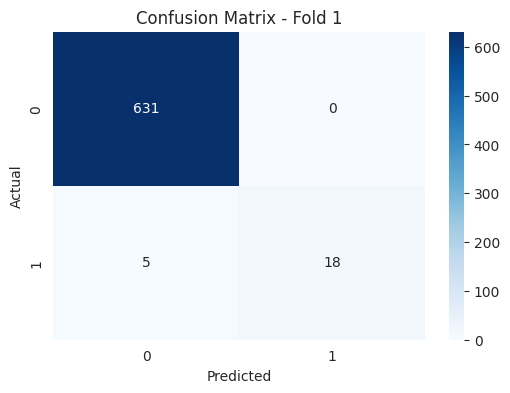

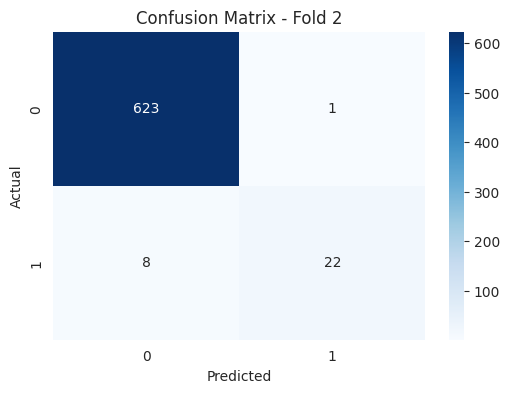

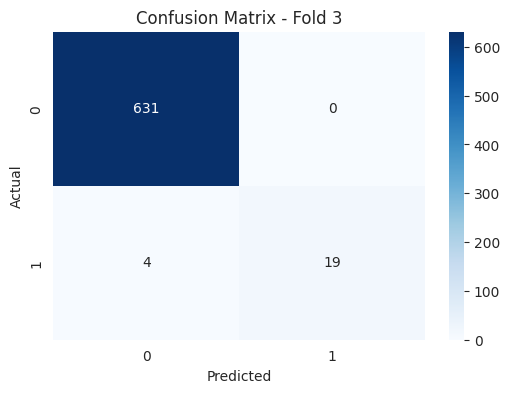

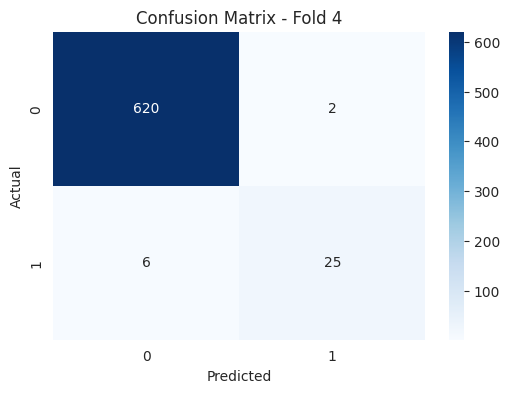

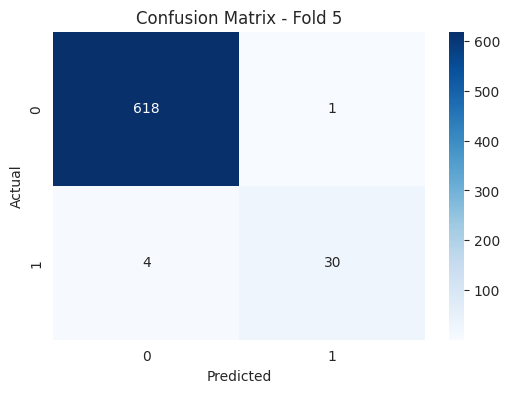

In [181]:
for i, cm in enumerate(conf_matrices, 1):
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - Fold {i}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()